In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '4'     
os.environ['OPENBLAS_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['VECLIB_MAXIMUM_THREADS'] = '4'
os.environ['NUMEXPR_NUM_THREADS'] = '4'

In [11]:
# Load data
train_df = pd.read_parquet("preprocessed_train_data.parquet")
test_df = pd.read_parquet("preprocessed_test_data.parquet")

In [ ]:
# Check dataset sizes
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (3888468, 11)
Test set shape: (747411, 22)


C:\Users\MSI\AppData\Local\Temp\ipykernel_17596\2393893868.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="FlagImpaye", data=train_df, palette="Set2")


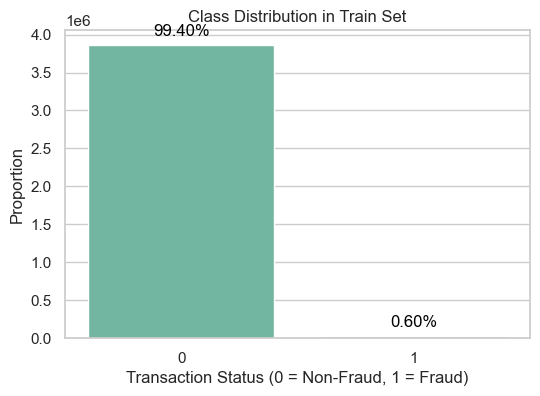

In [ ]:
# Visualizing class distribution in Train Set
plt.figure(figsize=(6, 4))
sns.countplot(x="FlagImpaye", data=train_df, palette="Set2")
plt.title("Class Distribution in Train Set")
plt.xlabel("Transaction Status (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Proportion")

# Adding percentage labels
total_train = len(train_df)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total_train:.2f}%'
    plt.gca().annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                       textcoords='offset points')
plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_17596\2393893868.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="FlagImpaye", data=train_df, palette="Set2")


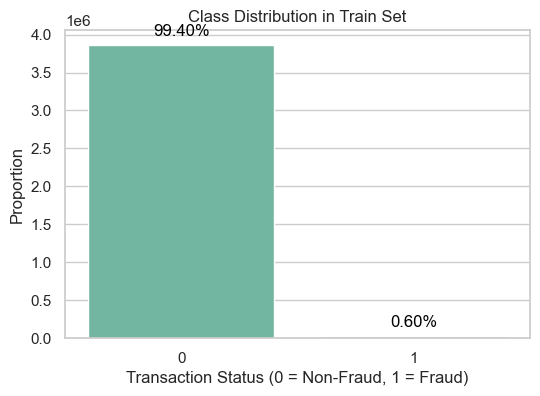

In [ ]:
# Visualizing class distribution in Train Set
plt.figure(figsize=(6, 4))
sns.countplot(x="FlagImpaye", data=train_df, palette="Set2")
plt.title("Class Distribution in Train Set")
plt.xlabel("Transaction Status (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Proportion")

# Adding percentage labels
total_train = len(train_df)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total_train:.2f}%'
    plt.gca().annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                       textcoords='offset points')
plt.show()

In [12]:
remaining_columns = train_df.columns
test_df = test_df[remaining_columns]

# Séparer features et target
X_train = train_df.drop(columns=["FlagImpaye"])
y_train = train_df["FlagImpaye"].astype(int)
X_test = test_df.drop(columns=["FlagImpaye"])
y_test = test_df["FlagImpaye"].astype(int)

In [13]:
# Dictionnaire des méthodes d'échantillonnage
sampling_methods = {
    "Original": None,
    "Undersampled": RandomUnderSampler(random_state=42),
    "Oversampled (SMOTE)": SMOTE(random_state=42),
    "Hybrid (SMOTE + Tomek)": SMOTETomek(random_state=42),
    "Oversampled (ADASYN)": ADASYN(random_state=42),
    "Class Weight Rebalancing": "balanced"
}

In [16]:
#Définir les classifieurs à tester

classifiers = {
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        n_jobs=8, 
        random_state=42
    ),
    "SVM": CalibratedClassifierCV(
        estimator=LinearSVC(max_iter=5000, dual=False, random_state=42),
        method='sigmoid',  
        cv=3               
    ),
    "LogReg": LogisticRegression(
        C=1.0,
        solver='lbfgs',
        max_iter=1000,
        n_jobs=8,
        random_state=42
    )
}

In [17]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# On définit un jeu de scores
scoring_metrics = {
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'pr_auc': 'average_precision'
}

In [ ]:
results = []

for sampler_name, sampler in sampling_methods.items():
    for clf_name, clf in classifiers.items():
        # Construire la pipeline
        if sampler_name == "Class Weight Rebalancing":
            if clf_name == "RandomForest":
                clf_ = RandomForestClassifier(
                    n_estimators=100,
                    max_depth=10,
                    min_samples_split=2,
                    n_jobs=8, 
                    random_state=42,
                    class_weight='balanced'
                )
            elif clf_name == "SVM":
                clf_ = CalibratedClassifierCV(
                    estimator=LinearSVC(max_iter=3000, random_state=42, dual=False, class_weight='balanced'),
                    method='sigmoid',
                    cv=3
                )
            elif clf_name == "LogReg":
                clf_ = LogisticRegression(
                    C=1.0,
                    solver='lbfgs',
                    max_iter=1000,
                    n_jobs=8,
                    random_state=42,
                    class_weight='balanced'
                )
            pipeline = Pipeline([
                ('clf', clf_)
            ])
        else:
            
            if sampler is not None:
                pipeline = Pipeline([
                    ('sampler', sampler),
                    ('clf', clf)
                ])
            else:
                
                pipeline = Pipeline([
                    ('clf', clf)
                ])

        combo_name = f"{sampler_name} + {clf_name}"

        print(f"\n=== Evaluating: {combo_name} ===")
        start_time = time.time()

        # cross_validate
        scores = cross_validate(
            pipeline,
            X_train, 
            y_train,
            cv=cv,
            scoring=scoring_metrics,
            n_jobs=8,
            return_train_score=False
        )
        end_time = time.time()
        exec_time = end_time - start_time

        results.append({
            'Sampler': sampler_name,
            'Classifier': clf_name,
            'F1 Mean': np.mean(scores['test_f1']),
            'F1 Std': np.std(scores['test_f1']),
            'Precision': np.mean(scores['test_precision']),
            'Recall': np.mean(scores['test_recall']),
            'PR AUC': np.mean(scores['test_pr_auc']),
            'Execution Time (s)': exec_time
        })

# Convertir en DataFrame
results_df = pd.DataFrame(results)


=== Evaluating: Original + RandomForest ===

=== Evaluating: Original + SVM ===

=== Evaluating: Original + LogReg ===

=== Evaluating: Undersampled + RandomForest ===

=== Evaluating: Undersampled + SVM ===

=== Evaluating: Undersampled + LogReg ===

=== Evaluating: Oversampled (SMOTE) + RandomForest ===

=== Evaluating: Oversampled (SMOTE) + SVM ===

=== Evaluating: Oversampled (SMOTE) + LogReg ===

=== Evaluating: Hybrid (SMOTE + Tomek) + RandomForest ===

=== Evaluating: Hybrid (SMOTE + Tomek) + SVM ===

=== Evaluating: Hybrid (SMOTE + Tomek) + LogReg ===

=== Evaluating: Oversampled (ADASYN) + RandomForest ===

=== Evaluating: Oversampled (ADASYN) + SVM ===

=== Evaluating: Oversampled (ADASYN) + LogReg ===

=== Evaluating: Class Weight Rebalancing + RandomForest ===

=== Evaluating: Class Weight Rebalancing + SVM ===

=== Evaluating: Class Weight Rebalancing + LogReg ===


In [19]:
display(results_df.sort_values(by='F1 Mean', ascending=False))


,Sampler,Classifier,F1 Mean,F1 Std,Precision,Recall,PR AUC,Execution Time (s)
0,Original,RandomForest,0.052935,0.003832,0.886528,0.027285,0.116641,544.778965
15,Class Weight Rebalancing,RandomForest,0.040008,0.000128,0.020603,0.688126,0.079581,558.306958
9,Hybrid (SMOTE + Tomek),RandomForest,0.036227,0.000645,0.018690,0.587295,0.054345,1363.315678
6,Oversampled (SMOTE),RandomForest,0.035972,0.000601,0.018558,0.584083,0.054534,1162.885563
12,Oversampled (ADASYN),RandomForest,0.035504,0.000530,0.018305,0.587295,0.051939,1094.808123
3,Undersampled,RandomForest,0.034716,0.000159,0.017777,0.736829,0.075014,15.982407
4,Undersampled,SVM,0.029196,0.000723,0.014921,0.675790,0.049879,5.066890
17,Class Weight Rebalancing,LogReg,0.028457,0.000476,0.014530,0.684743,0.050107,282.816202
5,Undersampled,LogReg,0.028171,0.000074,0.014380,0.687098,0.049666,6.848765
2,Original,LogReg,0.028029,0.002355,0.409217,0.014521,0.037912,273.302398


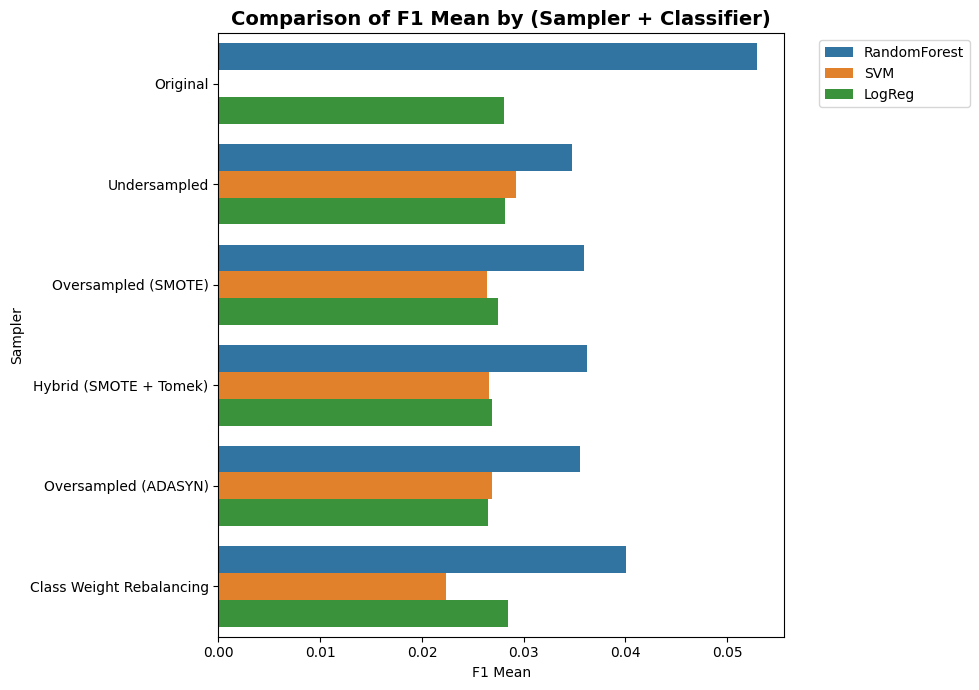

In [20]:
plt.figure(figsize=(10,7))
sns.barplot(data=results_df, x='F1 Mean', y='Sampler', hue='Classifier', orient='h')
plt.title("Comparison of F1 Mean by (Sampler + Classifier)", fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()